In [1]:
from IPython import display
%matplotlib inline
import cv2
import gym
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, sys, shutil
import torch
import omegaconf
import time
import torch

import mbrl.env.cartpole_continuous as cartpole_env
import mbrl.env.reward_fns as reward_fns
import mbrl.env.termination_fns as termination_fns
import mbrl.models as models
import mbrl.planning as planning
import mbrl.util.common as common_util
import mbrl.util as util

import tactile_gym.rl_envs
from tactile_gym.sb3_helpers.params import import_parameters

%load_ext autoreload
%autoreload 2

mpl.rcParams.update({"font.size": 16})

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# produce a display to render image
from pyvirtualdisplay import Display
_display = Display(visible=False, size=(1400, 900))
_ = _display.start()

In [7]:
# Define model working directorys
model_filename = 'training_model'
work_dir = os.path.join(os.getcwd(), model_filename)
print(work_dir)

/home/qt21590/Documents/Projects/tactile_gym_mbrl/mbrl-lib/notebooks/training_model


In [8]:
# reed csv
evaluation_result_directory = os.path.join(work_dir, "evaluation_result")
data_columns = ['trial','trial_steps', 'time_steps', 'tcp_x','tcp_y','tcp_z','contact_x', 'contact_y', 'contact_z', 'goal_x', 'goal_y', 'goal_z', 'rewards', 'contact', 'dones']
df = pd.read_csv(os.path.join(work_dir, 'training_results.csv'), names = data_columns)

In [9]:
df.query("trial_steps==1500")

,trial,trial_steps,time_steps,tcp_x,tcp_y,tcp_z,contact_x,contact_y,contact_z,goal_x,goal_y,goal_z,rewards,contact,dones
34566.0,38.0,1500.0,109.441667,-0.082347,0.273196,-7.338822e-07,-0.082796,0.263753,0.0,-0.18,0.014435,0.0,-2873.532710,1.0,1.0
38763.0,43.0,1500.0,102.437500,-0.107226,-0.159859,-2.421439e-07,-0.106556,-0.156542,0.0,-0.18,0.022117,0.0,-1972.453699,1.0,1.0
88982.0,89.0,1500.0,117.600000,-0.195994,0.297952,5.252659e-06,-0.195226,0.293118,0.0,-0.18,0.017999,0.0,-2297.396181,1.0,1.0
96585.0,95.0,1500.0,113.937500,-0.196282,0.231243,6.027520e-06,-0.193892,0.225311,0.0,-0.18,0.027625,0.0,-2238.438350,1.0,1.0


In [4]:
# Load the environment 
env_name = 'object_push-v0'
env_kwargs_file = 'env_kwargs'
env_kwargs_dir = os.path.join(work_dir, env_kwargs_file)
env_kwargs = omegaconf.OmegaConf.load(env_kwargs_dir)

env = gym.make(env_name, **env_kwargs)
seed = 0
env.seed(seed)
rng = np.random.default_rng(seed=0)
generator = torch.Generator(device=device)
generator.manual_seed(seed)
obs_shape = env.observation_space.shape
act_shape = env.action_space.shape

argv[0]=
Loaded EGL 1.5 after reload.


pybullet build time: Mar  8 2021 17:26:24


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 3090/PCIe/SSE2
GL_VERSION=4.6.0 NVIDIA 495.29.05
GL_SHADING_LANGUAGE_VERSION=4.60 NVIDIA
Version = 4.6.0 NVIDIA 495.29.05
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 3090/PCIe/SSE2
ven = NVIDIA Corporation
ven = NVIDIA Corporation


In [13]:
def make_evaluation_goals(num_trials):

    # Create evenly distributed goals along the edge
    n_point_per_side, n_random = divmod(num_trials, len(env.goal_edges))
    evaluation_goals = np.array([])
    for edge in env.goal_edges:
        # random x-axis
        goal_edges = np.zeros((n_point_per_side, 2))
        if edge[0] == 0:
            if edge[1] == -1:
                y = env.goal_y_min
            else:
                y = env.goal_y_max
            x = np.linspace(env.goal_x_min, env.goal_x_max, num=n_point_per_side)
        # random y axis
        else:
            if edge[0] == -1:
                x = env.goal_x_min
            else:
                x = env.goal_x_max
            y = np.linspace(env.goal_y_min, env.goal_y_max, num=n_point_per_side)
        goal_edges[:, 0] = x
        goal_edges[:, 1] = y
        evaluation_goals = np.hstack([
            *evaluation_goals,
            *goal_edges
        ])

    # get unique goals
    evaluation_goals = evaluation_goals.reshape(n_point_per_side*len(env.goal_edges), 2)
    evaluation_goals = np.unique(evaluation_goals,axis=0)

    # Fill in rest with random goals
    for i in range(num_trials - len(evaluation_goals)):
        evaluation_goals = np.append(evaluation_goals, [np.array(env.random_single_goal())], axis=0)
    
    return evaluation_goals

print(make_evaluation_goals(10))

[[0.000000 -0.180000]
 [0.000000 0.180000]
 [0.090000 -0.180000]
 [0.090000 0.180000]
 [0.180000 -0.180000]
 [0.180000 0.000000]
 [0.180000 0.180000]
 [0.154389 -0.180000]
 [0.123015 -0.180000]
 [0.175906 -0.180000]]


In [6]:
# Get cfg and agent cfg
config_file = 'cfg_dict'
config_dir = os.path.join(work_dir, config_file)
cfg = omegaconf.OmegaConf.load(config_dir)
trial_length= cfg.overrides.trial_length

agent_config_file = 'agent_cfg'
agent_config_dir = os.path.join(work_dir, agent_config_file)
agent_cfg = omegaconf.OmegaConf.load(agent_config_dir)

# Re-map device
map_location = None
if cfg['dynamics_model']['device'] != device:
    cfg['dynamics_model']['device'] = device
    agent_cfg['optimizer_cfg']['device'] = device
    map_location = torch.device(device)
    
dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape, work_dir)
model_env = models.ModelEnvPushing(env, dynamics_model, termination_fn=None, reward_fn=None, generator=generator)
replay_buffer = common_util.create_replay_buffer(cfg, obs_shape, act_shape, rng=rng)

# Create dyanmics, replay buffer and agent 
# dynamics_model.load(work_dir, map_location=map_location)
# replay_buffer.load(work_dir)
# dynamics_model.update_normalizer(replay_buffer.get_all())  # update normalizer stats  

# Create agent 
agent = planning.create_trajectory_optim_agent_for_model(
    model_env,
    agent_cfg,
    num_particles=20
)

/home/qt21590/anaconda3/envs/tactile_gym_mbrl/lib/python3.9/site-packages/hydra/utils.py:32: UserWarning: `OmegaConf.is_none()` is deprecated, see https://github.com/omry/omegaconf/issues/547
  if OmegaConf.is_none(config):


In [6]:
def get_states_from_obs(obs):
    if "goal_excluded" in env.observation_mode:
        if env.planar_states == True:
            # tcp_pos_workframe = np.zeros(3)
            # tcp_orn_workframe = np.zeros(4)
            cur_obj_pos_workframe = np.zeros(3)
            # cur_obj_orn_workframe = np.zeros(4)

            # tcp_pos_workframe[0:2] = obs[0:2]
            # tcp_orn_workframe[2:4] = obs[2:4]
            cur_obj_pos_workframe[0:2]= obs[4:6]
            # cur_obj_orn_workframe[:, 2:4] = obs[4:6]
        else:   
            # tcp_pos_workframe = obs[0:3]
            # tcp_orn_workframe = obs[0:4]
            cur_obj_pos_workframe = obs[4:7]
            # cur_obj_orn_workframe = obs[7:11]

    else:
        if env.planar_states == True: 
            # tcp_pos_to_goal_workframe = np.zeros(3)
            # tcp_orn_to_goal_workframe = np.zeros(4)
            cur_obj_pos_to_goal_workframe = np.zeros(3)
            # cur_obj_orn_to_goal_workframe = np.zeros(4)

            # tcp_pos_to_goal_workframe[0:2] = obs[0:2]
            # tcp_orn_to_goal_workframe[2:4] = obs[0:2]
            cur_obj_pos_to_goal_workframe[0:2]= obs[2:4]
            # cur_obj_orn_to_goal_workframe[2:4] = obs[4:6]
        else:
            # tcp_pos_to_goal_workframe = obs[0:3]
            # tcp_orn_to_goal_workframe = obs[0:4]
            cur_obj_pos_to_goal_workframe = obs[4:7]
            # cur_obj_orn_to_goal_workframe = obs[7:11]

        # tcp_pos_workframe = obs[0:3] + env.goal_pos_workframe
        cur_obj_pos_workframe = cur_obj_pos_to_goal_workframe + env.goal_pos_workframe

    return cur_obj_pos_workframe

Terminated at step 452 with reward 27.86713717443334, goal reached: True
Terminated at step 586 with reward -195.14871180811542, goal reached: False
Terminated at step 471 with reward 22.392214437788738, goal reached: True
Terminated at step 480 with reward 5.324551071870275, goal reached: True
Terminated at step 481 with reward 9.18355038674926, goal reached: True
Terminated at step 436 with reward 27.003945253001277, goal reached: True
Terminated at step 576 with reward -207.06524668481438, goal reached: False
Terminated at step 461 with reward 4.139277105973804, goal reached: True
Terminated at step 460 with reward 21.85248252726413, goal reached: True
Terminated at step 465 with reward 15.392241954388538, goal reached: True
The average reward over 10 episodes is -26.905855858146047


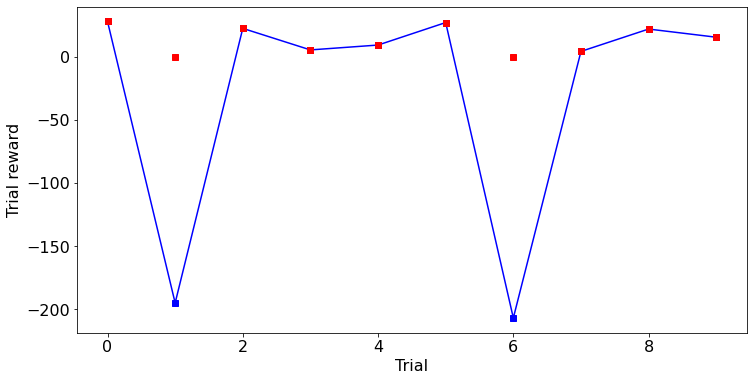

In [7]:
# Main PETS loop
num_test_trials = 10
all_rewards = []
evaluation_result = []
goal_reached = []
plan_time = 0.0
train_time = 0.0
save_vid = True
render = True

if save_vid:
    record_every_n_frames = 1
    render_img = env.render(mode="rgb_array")
    render_img_size = (render_img.shape[1], render_img.shape[0])
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(
        os.path.join(work_dir, "evaluated_policy.mp4"),
        fourcc,
        24.0,
        render_img_size,
    )

for trial in range(num_test_trials):
    obs = env.reset()    
    agent.reset()
    
    done = False
    trial_reward = 0.0
    trial_pb_steps = 0.0
    steps_trial = 0
    
    tcp_pos_workframe, _, _, _, _ = env.robot.arm.get_current_TCP_pos_vel_workframe()
    cur_obj_pos_workframe = get_states_from_obs(obs)
    evaluation_result.append(np.hstack([trial, 
                                    steps_trial, 
                                    trial_pb_steps,
                                    tcp_pos_workframe, 
                                    cur_obj_pos_workframe, 
                                    env.goal_pos_workframe, 
                                    trial_reward, 
                                    False,
                                    done]))

    while not done:

        # --- Doing env step using the agent and adding to model dataset ---
        start_plan_time = time.time()
        action = agent.act(obs, **{})
        next_obs, reward, done, info = env.step(action)
        plan_time = time.time() - start_plan_time

        if render:
            render_img = env.render(mode="rgb_array")
        else:
            render_img = None
        
        obs = next_obs
        trial_reward += reward
        trial_pb_steps += info["num_of_pb_steps"]
        steps_trial += 1
        
        tcp_pos_workframe, _, _, _, _ = env.robot.arm.get_current_TCP_pos_vel_workframe()
        cur_obj_pos_workframe = get_states_from_obs(obs)
        evaluation_result.append(np.hstack([trial,
                                        steps_trial,
                                        trial_pb_steps * env._sim_time_step,
                                        tcp_pos_workframe, 
                                        cur_obj_pos_workframe, 
                                        env.goal_pos_workframe, 
                                        trial_reward, 
                                        info["tip_in_contact"],
                                        done]))

         # use record_every_n_frames to reduce size sometimes
        if save_vid and steps_trial % record_every_n_frames == 0:

            # warning to enable rendering
            if render_img is None:
                sys.exit('Must be rendering to save video')

            render_img = cv2.cvtColor(render_img, cv2.COLOR_BGR2RGB)
            out.write(render_img)

        if steps_trial == trial_length:
            break
    
    print("Terminated at step {} with reward {}, goal reached: {}".format(steps_trial, trial_reward, env.single_goal_reached))
    all_rewards.append(trial_reward)

    # save goal reached data during training
    if env.single_goal_reached:
        goal_reached.append(trial_reward)
    else:
        goal_reached.append(0)

if save_vid:
    out.release()

print("The average reward over {} episodes is {}".format(num_test_trials, np.mean(all_rewards)))

# Save data 
evaluation_result = np.array(evaluation_result)
data_columns = ['trial','trial_steps', 'time_steps', 'tcp_x','tcp_y','tcp_z','contact_x', 'contact_y', 'contact_z', 'goal_x', 'goal_y', 'goal_z', 'rewards', 'contact', 'dones']
df = pd.DataFrame(evaluation_result, columns = data_columns)
pd.DataFrame(evaluation_result).to_csv(os.path.join(work_dir, "evaluation_results.csv"))

# plot evaluation results
evaluation_result_directory = os.path.join(work_dir, "evaluation_result")
if not os.path.exists(evaluation_result_directory):
    os.mkdir(evaluation_result_directory)
else:
    for filename in os.listdir(evaluation_result_directory):
        file_path = os.path.join(evaluation_result_directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

def plot_and_save_push_plots(df, trials, directory):
    loss_contact = False
    for trial in range(trials):
        fig_xy, ax = plt.subplots(figsize=(12, 6))
        ax.plot(df.query("trial==@trial")["tcp_x"], df.query("trial==@trial")["tcp_y"], "bs", label='tcp psosition')
        ax.plot(df.query("trial==@trial").query("contact==@loss_contact")["tcp_x"], df.query("trial==@trial").query("contact==@loss_contact")["tcp_y"], "g+", markersize=20)
        ax.plot(df.query("trial==@trial")["contact_x"], df.query("trial==@trial")["contact_y"], "rs", label='contact psosition')
        ax.plot(df.query("trial==@trial").query("contact==@loss_contact")["contact_x"], df.query("trial==@trial").query("contact==@loss_contact")["contact_y"], "gx", markersize=20)
        ax.plot(df.query("trial==@trial")["goal_x"].iloc[0], df.query("trial==@trial")["goal_y"].iloc[0], "x", markersize=20, markeredgecolor="black", label="goal position")
        ax.set_xlabel("x workframe")
        ax.set_ylabel("y workframe")
        ax.set_xlim([env.robot.arm.TCP_lims[0, 0], env.robot.arm.TCP_lims[0, 1]])
        ax.set_ylim([env.robot.arm.TCP_lims[1, 0], env.robot.arm.TCP_lims[1, 1]])
        ax.legend()
        fig_xy.savefig(os.path.join(directory, "workframe_plot_trial_{}.png".format(trial)))
        plt.close(fig_xy)

        fig_time_xy, axs = plt.subplots(1, 2, figsize=(14, 3.75), gridspec_kw={"width_ratios": [1, 1]})
        axs[0].plot(df.query("trial==@trial")["time_steps"], df.query("trial==@trial")["tcp_x"], "bs", label='tcp ')
        axs[0].plot(df.query("trial==@trial").query("contact==@loss_contact")["time_steps"], df.query("trial==@trial").query("contact==@loss_contact")["tcp_x"], "g+", markersize=20)
        axs[0].plot(df.query("trial==@trial")["time_steps"], df.query("trial==@trial")["contact_x"], "rs", label='contact')
        axs[0].plot(df.query("trial==@trial").query("contact==@loss_contact")["time_steps"], df.query("trial==@trial").query("contact==@loss_contact")["contact_x"], "gx", markersize=20)
        axs[0].set_xlabel("Time steps (s)")
        axs[0].set_ylabel("x axis workframe")
        axs[0].set_ylim([env.robot.arm.TCP_lims[0, 0], env.robot.arm.TCP_lims[0, 1]])
        axs[0].legend()
        axs[1].plot(df.query("trial==@trial")["time_steps"], df.query("trial==@trial")["tcp_y"], "bs", label='tcp')
        axs[1].plot(df.query("trial==@trial").query("contact==@loss_contact")["time_steps"], df.query("trial==@trial").query("contact==@loss_contact")["tcp_y"], "g+", markersize=20)
        axs[1].plot(df.query("trial==@trial")["time_steps"], df.query("trial==@trial")["contact_y"], "rs", label='contact')
        axs[1].plot(df.query("trial==@trial").query("contact==@loss_contact")["time_steps"], df.query("trial==@trial").query("contact==@loss_contact")["contact_y"], "gx", markersize=20)
        axs[1].set_xlabel("Time steps (s)")
        axs[1].set_ylabel("y axis workframe")
        axs[1].set_ylim([env.robot.arm.TCP_lims[1, 0], env.robot.arm.TCP_lims[1, 1]])
        axs[1].legend()
        fig_time_xy.savefig(os.path.join(directory, "time_plot_trial_{}.png".format(trial)))
        plt.close(fig_time_xy)

plot_and_save_push_plots(df, num_test_trials, evaluation_result_directory)

# Plot evaluation results
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(all_rewards, 'bs-', goal_reached, 'rs')
ax.set_xlabel("Trial")
ax.set_ylabel("Trial reward")
fig.savefig(os.path.join(work_dir, "evaluation_output.png"))


In [8]:
value = False
df.query("contact==@value")

,trial,trial_steps,time_steps,tcp_x,tcp_y,tcp_z,contact_x,contact_y,contact_z,goal_x,goal_y,goal_z,rewards,contact,dones
0,0.0,0.0,0.000000,0.000867,8.940697e-07,0.0,0.001000,0.000000,0.0,0.290000,-0.002932,0.0,0.000000,0.0,0.0
371,1.0,0.0,0.000000,0.000867,8.940697e-07,0.0,0.001000,0.000000,0.0,0.290000,0.081320,0.0,0.000000,0.0,0.0
723,2.0,0.0,0.000000,0.000867,8.940697e-07,0.0,0.001000,0.000000,0.0,0.131284,0.090000,0.0,0.000000,0.0,0.0
1080,3.0,0.0,0.000000,0.000867,8.940697e-07,0.0,0.001000,0.000000,0.0,0.290000,0.081728,0.0,0.000000,0.0,0.0
1429,4.0,0.0,0.000000,0.000867,8.940697e-07,0.0,0.001000,0.000000,0.0,0.290000,0.046337,0.0,0.000000,0.0,0.0
1809,5.0,0.0,0.000000,0.000867,8.940697e-07,0.0,0.001000,0.000000,0.0,0.290000,-0.049114,0.0,0.000000,0.0,0.0
2174,6.0,0.0,0.000000,0.000867,8.940697e-07,0.0,0.001000,0.000000,0.0,0.193069,0.090000,0.0,0.000000,0.0,0.0
2520,6.0,346.0,23.508333,0.253496,7.084626e-02,0.0,0.263106,0.056595,0.0,0.193069,0.090000,0.0,-57.931954,0.0,0.0
2614,7.0,0.0,0.000000,0.000867,8.940697e-07,0.0,0.001000,0.000000,0.0,0.220220,0.090000,0.0,0.000000,0.0,0.0
3054,8.0,0.0,0.000000,0.000867,8.940697e-07,0.0,0.001000,0.000000,0.0,0.193065,-0.090000,0.0,0.000000,0.0,0.0
